# RL4CO Quickstart Notebook

<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/examples/1-quickstart.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

[**Documentation**](https://rl4co.readthedocs.io/) |  [**Getting Started**](https://github.com/ai4co/rl4co/tree/main#getting-started) | [**Usage**](https://github.com/ai4co/rl4co/tree/main#usage) | [**Contributing**](#contributing) | [**Paper**](https://arxiv.org/abs/2306.17100) | [**Citation**](#cite-us)

In this notebook we will train the AttentionModel (AM) on the TSP environment for 20 nodes. On a GPU, this should less than 2 minutes!  🚀

![Alt text](https://user-images.githubusercontent.com/48984123/245925317-0db4efdd-1c93-4991-8f09-f3c6c1f35d60.png)

### Installation

In [1]:
## Uncomment the following line to install the package from PyPI
## You may need to restart the runtime in Colab after this
## Remember to choose a GPU runtime for faster training!

!pip install rl4co

  Obtaining dependency information for rl4co from https://files.pythonhosted.org/packages/db/6e/48fbfda61a4f9a898530a58ae5a12be6a8b5ad542fc54beb3028b76a14a5/rl4co-0.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/87/62/9773de14fe6c45c23649e98b83231fffd7b9892b6cf863251dc2afa73643/einops-0.8.1-py3-none-any.whl.metadata
  Obtaining dependency information for hydra-colorlog from https://files.pythonhosted.org/packages/40/50/a08b0453c18088da369991d015ef3902a9ab532b515a41f1bfbe1394854d/hydra_colorlog-1.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for hydra-core from https://files.pythonhosted.org/packages/c6/50/e0edd38dcd63fb26a8547f13d28f7a008bc4a3fd4eb4ff030673f22ad41a/hydra_core-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for lightning>=2.1.0 from https://files.pythonhosted.org/packages/d6/e9/36b340c7ec01dad6f034481e98fc9fc0133307beb05c714c0542af98bbde/lightning-2.6.0-py3-no

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

import torch

from rl4co.envs import TSPEnv
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.utils.trainer import RL4COTrainer

### Environment, Policy and Model

Full documentation of:https://rl4.co/docs/content/api/envs/base/

- Base environment class [here](https://rl4.co/docs/content/api/envs/base/)
- Base policy class [here](https://rl4.co/docs/content/api/networks/base_policies/)
- Base model class [here](https://rl4.co/docs/content/api/rl/base/)

In [3]:
# RL4CO env based on TorchRL
env = TSPEnv(generator_params={'num_loc': 50})

# Policy: neural network, in this case with encoder-decoder architecture
policy = AttentionModelPolicy(env_name=env.name, 
                              embed_dim=128,
                              num_encoder_layers=3,
                              num_heads=8,
                            )

# RL Model: REINFORCE and greedy rollout baseline
model = REINFORCE(env, 
                    policy,
                    baseline="rollout",
                    batch_size=512,
                    train_data_size=100_000,
                    val_data_size=10_000,
                    optimizer_kwargs={"lr": 1e-4},
                    ) 

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


### Test greedy rollout with untrained model and plot

Problem 1 | Cost: 14.498
Problem 2 | Cost: 23.551
Problem 3 | Cost: 12.228


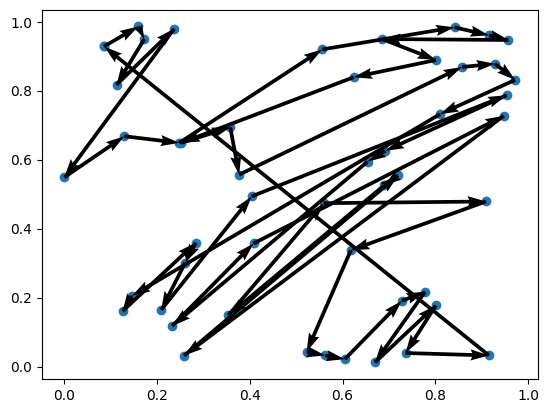

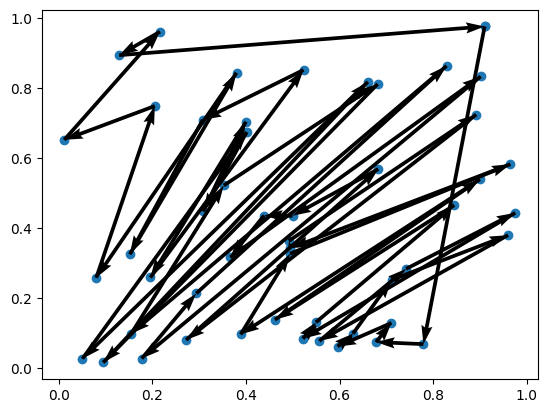

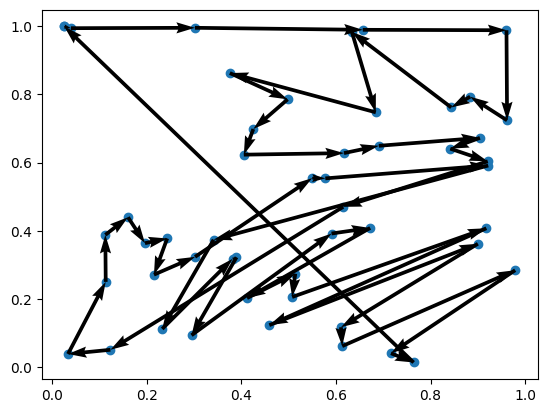

In [4]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

### Trainer

The RL4CO trainer is a wrapper around PyTorch Lightning's `Trainer` class which adds some functionality and more efficient defaults

In [5]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


### Fit the model

In [6]:
trainer.fit(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ env      │ TSPEnv               │      0 │ train │     0 │
│ 1 │ policy   │ AttentionModelPolicy │  710 K │ train │     0 │
│ 2 │ baseline │ WarmupBaseline       │  710 K │ train │     0 │
└───┴──────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 68                                                                                           
Total FLOPs: 0

Output()

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/dat
a_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing 
the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/dat
a_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:534:
Found 68 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If 
this is intentional, you can ignore this warning.

`Trainer.fit` stopped: `max_epochs=3` reached.


### Testing

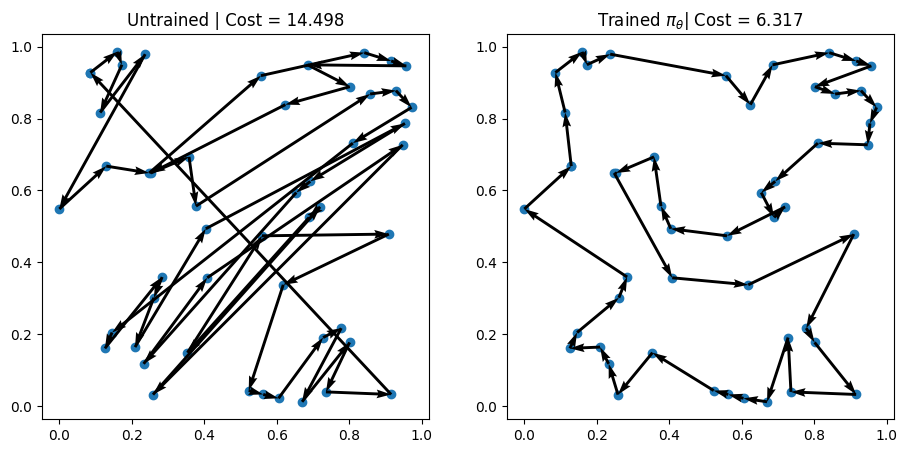

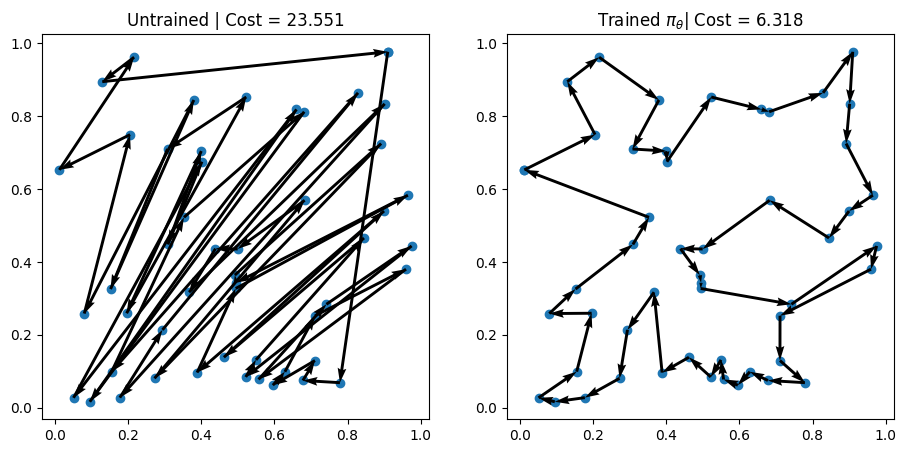

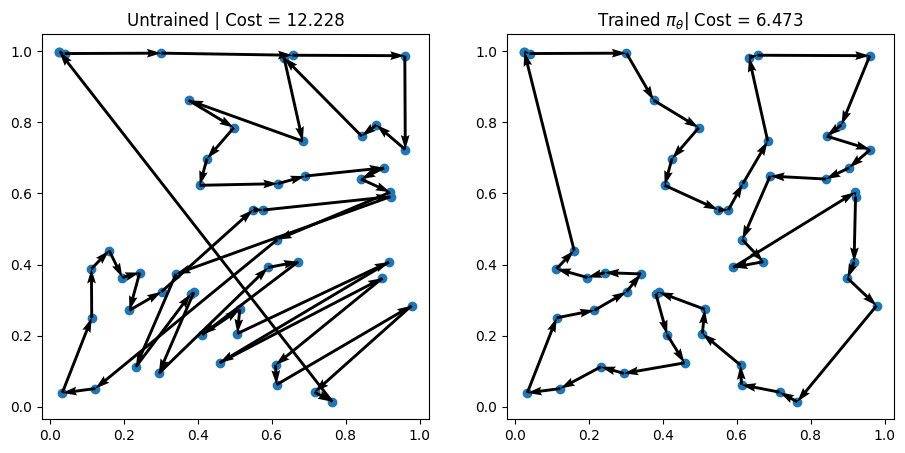

In [7]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

We can see that even after just 3 epochs, our trained AM is able to find much better solutions than the random policy! 🎉

In [8]:
# Optionally, save the checkpoint for later use (e.g. in tutorials/4-search-methods.ipynb)
trainer.save_checkpoint("tsp-quickstart.ckpt")

`weights_only` was not set, defaulting to `False`.
